# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents

## 4.2 Introduction

## 4.3 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# import seaborn as sns
# from sklearn import __version__ as sklearn_version
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from pycaret.regression import *
import os, glob
from statsmodels.tsa.stattools import acf

import datetime
%matplotlib inline  

## 4.4 Load Data

In [2]:
train_df = pd.read_pickle('../data/train_df.pkl')
# delta_invQ_df = pd.read_pickle('../data/roll_amp_spectrum_ratio_dinvQ.pkl')
# train_df = pd.concat([train_df, delta_invQ_df], axis = 1)

train_df.head()

,ttf,mean,median,std,kurt,skew,min,max,qt5,qt25,...,amp_spec_ac4,amp_spec_ac5,amp_spec_ac6,amp_spec_ac7,amp_spec_ac8,amp_spec_ac9,amp_spec_ac10,amp_spec_ac11,mean_centroids,bandwidth
0,1.430797,4.884113,5.0,5.101106,33.662481,-0.024061,-98.0,104.0,-2.0,3.0,...,0.273903,0.281398,0.263396,0.274093,0.265804,0.275402,0.270935,0.275654,3046.815584,3172.691640
1,1.411696,4.746800,5.0,6.173383,116.797377,0.526284,-154.0,181.0,-2.0,2.0,...,0.403779,0.383214,0.394499,0.403423,0.393415,0.377611,0.397787,0.393683,3061.901059,3168.381790
2,1.391499,4.725767,5.0,6.588824,98.758517,0.390561,-154.0,181.0,-2.0,2.0,...,0.432795,0.412530,0.417894,0.433983,0.420324,0.416430,0.411985,0.441623,3056.587710,3159.498185
3,1.372298,4.753000,5.0,5.715036,33.744779,-0.107664,-115.0,111.0,-2.0,2.0,...,0.337132,0.326059,0.338600,0.329168,0.331256,0.335468,0.334006,0.351540,3059.965942,3163.895816
4,1.353196,4.906393,5.0,6.967397,33.555211,0.217391,-106.0,140.0,-3.0,2.0,...,0.409318,0.406143,0.411074,0.407628,0.408582,0.399507,0.411440,0.406676,2976.351964,3123.418418


In [3]:
# delete some features with small number of unique values
# train_df.drop(columns = ['median'], inplace = True)
# label_df = pd.read_pickle('../data/label.pkl')
# train_df = pd.concat([label_df,train_df], axis = 1)
# train_df.drop(columns = [col for col in train_df.columns if '_median_smedian' in col], inplace = True)
# event_df = pd.read_pickle('../data/eventgroup.pkl')


## 4.6 Auto ML using Pycaret

In [4]:
# generate 100 groups randomly
# np.random.seed(45)
# fold_group100 = pd.Series(np.random.randint(0,100, size=event_df.shape).reshape(-1,))

In [3]:
# init setup

# cv = LeaveOneGroupOut()
s = setup(train_df,
          target = 'ttf', 
          normalize = True,          
          session_id = 123
         ) #event_df['event_id'] , fold_group100

,Description,Value
0,Session id,123
1,Target,ttf
2,Target type,Regression
3,Data shape,"(8355, 244)"
4,Train data shape,"(5848, 244)"
5,Test data shape,"(2507, 244)"
6,Numeric features,243
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [4]:
# model training and selection
best = compare_models(sort = 'MAE', exclude = ['par','lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.9435,6.2879,2.5066,0.5278,0.4842,7.3567,33.9310
rf,Random Forest Regressor,1.9545,6.3243,2.5135,0.5252,0.4851,7.1585,79.2720
lightgbm,Light Gradient Boosting Machine,1.9605,6.3447,2.5177,0.5240,0.4785,6.7775,3.9700
gbr,Gradient Boosting Regressor,1.9979,6.5452,2.5572,0.5087,0.4868,7.1879,31.0480
knn,K Neighbors Regressor,2.0285,7.0989,2.6635,0.4665,0.5021,6.2666,0.4100
huber,Huber Regressor,2.0692,7.3260,2.7054,0.4494,0.5134,7.5145,2.4200
ridge,Ridge Regression,2.0855,7.2004,2.6819,0.4593,0.5190,7.1698,0.5000
lr,Linear Regression,2.0970,7.4025,2.7188,0.4446,0.5242,7.1131,2.9110
br,Bayesian Ridge,2.0981,7.1950,2.6813,0.4599,0.5183,7.5473,0.3720
omp,Orthogonal Matching Pursuit,2.1201,7.3447,2.7090,0.4487,0.5233,7.7587,0.3040


In [7]:
# analyze best model
# fast result: Hyperparameters, Residuals, Prediction Error, Cooks Distance, Feature Importance, Interactive Residuals
# evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## 4.7 Create models using pycaret

### 4.7.1 Light Gradient Boosting Machine

In [5]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9672,6.3049,2.5110,0.5269,0.4414,3.1026
1,1.8872,5.8113,2.4107,0.5047,0.4778,2.7621
2,1.9757,6.4208,2.5339,0.5647,0.4685,6.3080
3,1.8787,5.8484,2.4183,0.5092,0.4431,5.8089
4,1.9217,5.8782,2.4245,0.5103,0.4516,3.5302
5,1.9408,6.3874,2.5273,0.5379,0.4894,2.8243
6,1.9770,6.4828,2.5461,0.5279,0.4986,3.3866
7,1.9652,6.5769,2.5645,0.5270,0.4968,5.8185
8,2.0241,6.6816,2.5849,0.5393,0.4959,2.1829


### 4.7.2 Random Forest

In [6]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8984,5.9189,2.4329,0.5559,0.4356,3.2035
1,1.8605,5.7004,2.3876,0.5141,0.4785,3.1441
2,1.9795,6.3994,2.5297,0.5661,0.4756,6.6860
3,1.8998,6.0024,2.4500,0.4962,0.4561,6.0123
4,1.9430,6.0616,2.4620,0.4950,0.4656,3.8954
5,1.9341,6.4605,2.5417,0.5326,0.4965,3.0630
6,1.9570,6.5192,2.5533,0.5253,0.5049,3.4961
7,1.9844,6.6754,2.5837,0.5199,0.5054,5.9046
8,1.9809,6.3090,2.5118,0.5650,0.4986,2.3276


### 4.7.3 Extra Trees Regressor

In [7]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9145,6.1088,2.4716,0.5416,0.4455,3.2996
1,1.8695,5.7914,2.4065,0.5064,0.4799,3.3362
2,1.9646,6.4289,2.5355,0.5641,0.4748,7.4948
3,1.8963,6.0034,2.4502,0.4961,0.4551,6.5489
4,1.9212,5.8816,2.4252,0.5100,0.4584,3.7976
5,1.9221,6.3246,2.5149,0.5425,0.4917,3.0215
6,1.9538,6.4821,2.5460,0.5280,0.5032,3.4355
7,1.9521,6.5178,2.5530,0.5312,0.5029,6.0367
8,1.9631,6.2622,2.5024,0.5682,0.4976,2.4354


### 4.7.4 Gradient Boosting Regressor

In [8]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9941,6.4261,2.5350,0.5178,0.4491,3.1399
1,1.9147,5.8594,2.4206,0.5006,0.4838,3.1148
2,2.0046,6.4557,2.5408,0.5623,0.4713,7.4767
3,1.9401,6.1526,2.4804,0.4836,0.4531,5.3783
4,1.9734,6.1633,2.4826,0.4865,0.4681,3.8685
5,1.9779,6.6653,2.5817,0.5178,0.5012,3.0720
6,2.0143,6.7259,2.5934,0.5102,0.5094,3.4820
7,2.0373,7.0734,2.6596,0.4913,0.5047,6.1707
8,2.0308,6.7417,2.5965,0.5351,0.5012,2.3947


## 4.8 Tune a Model

### 4.8.1 Light Gradient Boosting Machine

In [9]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9418,6.2805,2.5061,0.5288,0.4415,3.0128
1,1.9184,6.1085,2.4715,0.4793,0.4917,3.0462
2,1.9857,6.4870,2.5470,0.5602,0.4728,6.4730
3,1.9169,6.0550,2.4607,0.4918,0.4490,5.8519
4,1.9381,6.1394,2.4778,0.4885,0.4554,3.4633
5,1.9815,6.6979,2.5880,0.5155,0.4975,2.8284
6,1.9707,6.6398,2.5768,0.5165,0.5044,3.3478
7,1.9709,6.6590,2.5805,0.5211,0.4956,5.9799
8,1.9935,6.5333,2.5560,0.5495,0.4958,2.3109


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [10]:
#tuned model object is stored in the variable 'tuned_lightgbm'. 
print(tuned_lightgbm)

LGBMRegressor(random_state=123)


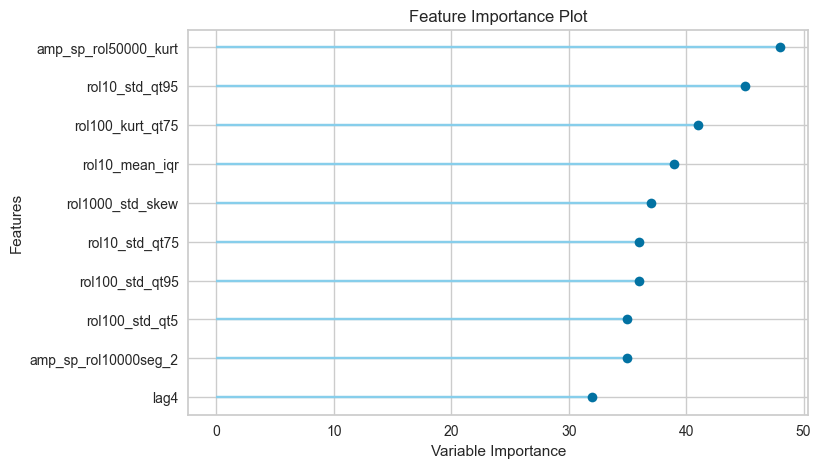

In [11]:
plot_model(tuned_lightgbm, plot='feature')

Q: Why the feature importance is so high in lightgbm model? What does it indicate?

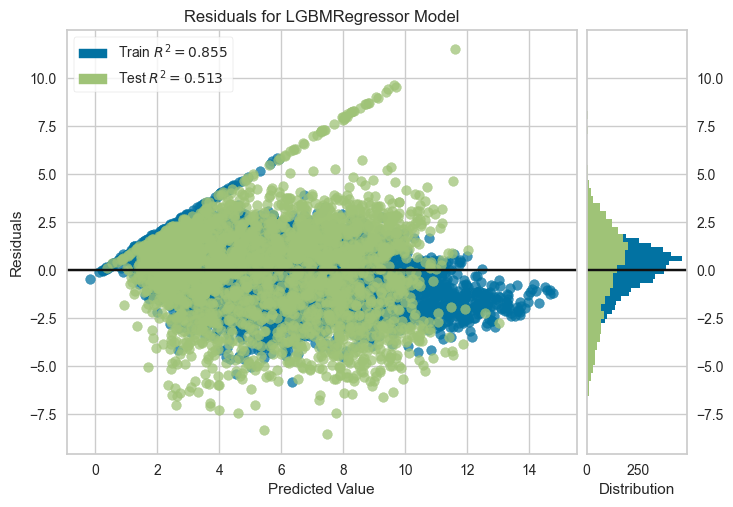

In [12]:
plot_model(tuned_lightgbm)

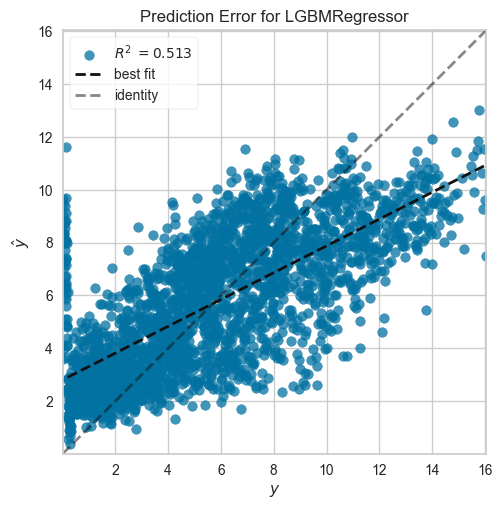

In [13]:
plot_model(tuned_lightgbm, plot = 'error')

In [14]:
pred_holdout = predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0057,6.5855,2.5662,0.5127,0.4976,4.0398


### 4.8.2 Random Forest

In [15]:
tuned_rf = tune_model(rf, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9251,6.1322,2.4763,0.5399,0.4470,3.3165
1,1.8613,5.7692,2.4019,0.5083,0.4801,3.4070
2,1.9794,6.4460,2.5389,0.5629,0.4711,7.1655
3,1.9195,6.0751,2.4648,0.4901,0.4577,6.4997
4,1.9353,5.9869,2.4468,0.5012,0.4606,3.8302
5,1.9426,6.4520,2.5401,0.5332,0.4957,3.1098
6,1.9914,6.6161,2.5722,0.5182,0.5047,3.3695
7,1.9821,6.6963,2.5877,0.5184,0.5068,6.0913
8,1.9958,6.4937,2.5483,0.5522,0.4993,2.4471


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


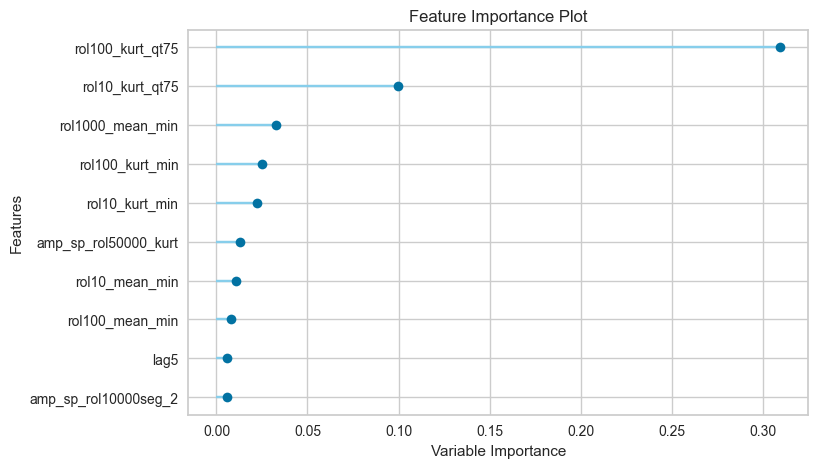

In [16]:
plot_model(tuned_rf, plot='feature')

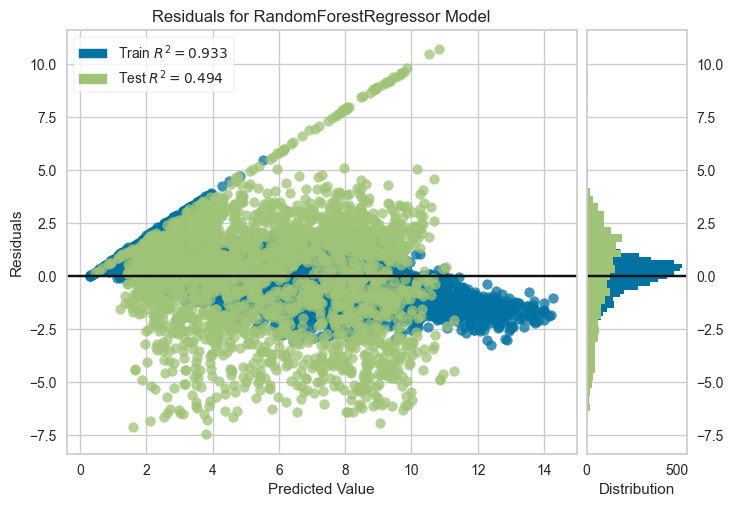

In [17]:
plot_model(tuned_rf)

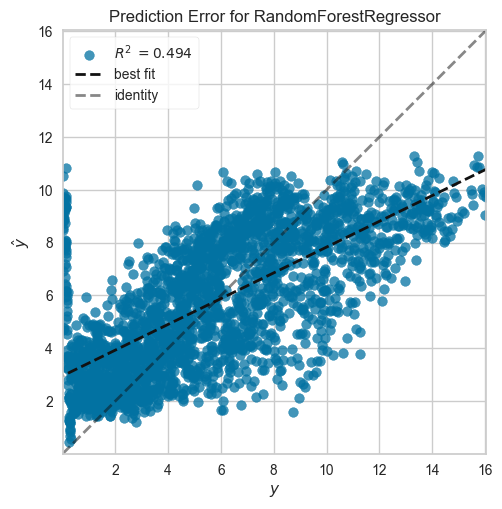

In [18]:
plot_model(tuned_rf, plot = 'error')

In [19]:
pred_holdout = predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.0359,6.8385,2.6151,0.4939,0.5120,4.2911


### 4.8.3 Extra Trees Regressor

In [20]:
tuned_et = tune_model(et, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9756,6.3762,2.5251,0.5216,0.4589,3.3734
1,1.9088,5.9947,2.4484,0.4890,0.4941,3.4937
2,2.0185,6.6278,2.5744,0.5506,0.4856,7.5505
3,1.9703,6.2481,2.4996,0.4756,0.4695,6.6526
4,1.9768,6.2218,2.4944,0.4817,0.4741,3.8672
5,2.0214,6.9272,2.6320,0.4989,0.5148,3.3599
6,2.0389,6.8639,2.6199,0.5002,0.5167,3.4862
7,2.0575,7.1104,2.6665,0.4886,0.5220,6.2496
8,2.0524,6.8968,2.6262,0.5244,0.5147,2.6322


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


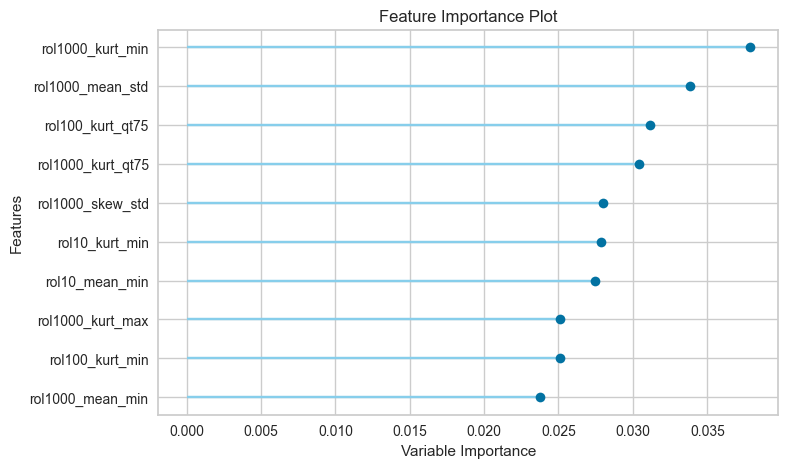

In [21]:
plot_model(tuned_et, plot='feature')

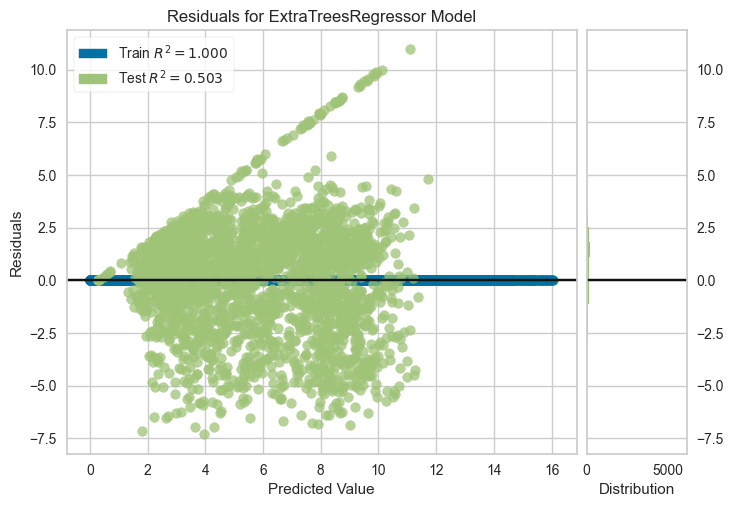

In [22]:
plot_model(tuned_et)

Q: Is it a good idea to dismiss Extra Tree Regressor? It is heavily over fitted, even though it has top 3 score.

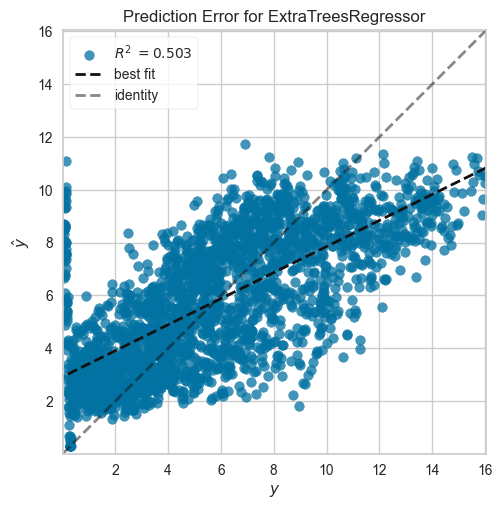

In [23]:
plot_model(tuned_et, plot = 'error')

In [24]:
pred_holdout = predict_model(tuned_et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.0114,6.7106,2.5905,0.5034,0.5088,4.2636


### 4.8.4 Gradient Boosting Regressor

In [25]:
tuned_gbr = tune_model(gbr, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9706,6.4531,2.5403,0.5158,0.4413,2.8690
1,1.8991,5.8712,2.4231,0.4996,0.4763,2.3708
2,1.9753,6.6060,2.5702,0.5521,0.4718,5.4703
3,1.9593,6.5186,2.5532,0.4529,0.4707,6.7604
4,1.9562,6.3382,2.5176,0.4720,0.4681,4.1381
5,2.0043,6.8117,2.6099,0.5072,0.5024,2.9276
6,1.9909,6.7786,2.6036,0.5064,0.5034,3.3087
7,1.9884,6.8165,2.6108,0.5098,0.4990,5.5390
8,1.9902,6.6670,2.5821,0.5403,0.5001,2.2823


Fitting 10 folds for each of 10 candidates, totalling 100 fits


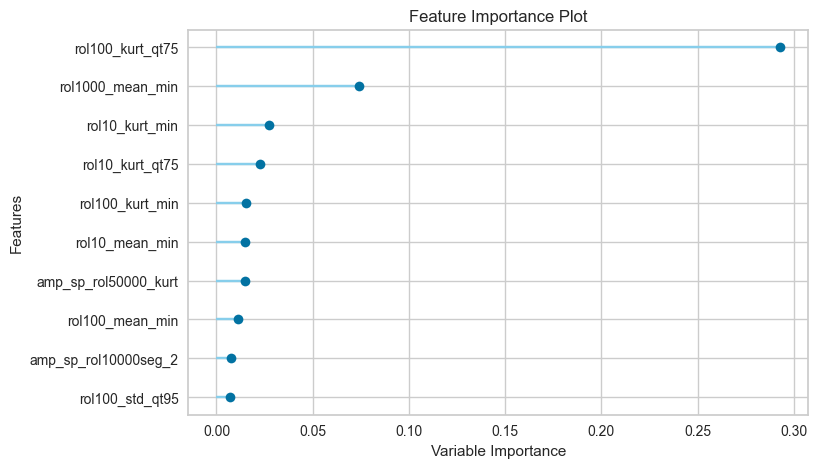

In [26]:
plot_model(tuned_gbr, plot='feature')

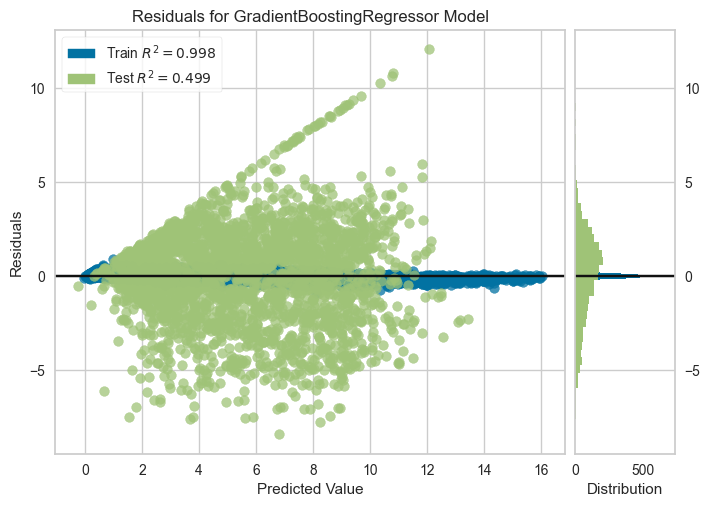

In [27]:
plot_model(tuned_gbr)

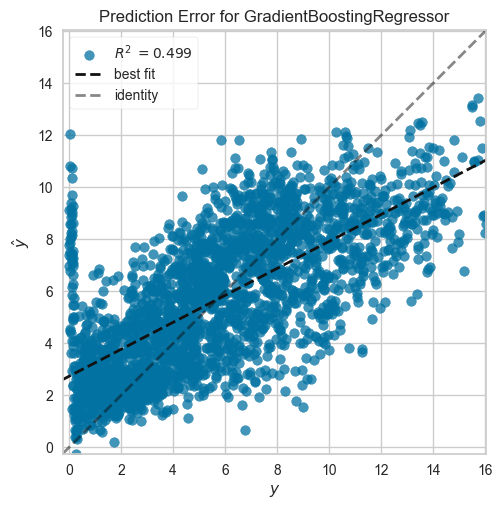

In [28]:
plot_model(tuned_gbr, plot = 'error')

In [29]:
pred_holdout = predict_model(tuned_gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.0023,6.7672,2.6014,0.4992,0.5011,4.0465


## 4.9 Voting Regressor

### 4.9.1 no weights

In [42]:
top03 = compare_models(include = [tuned_lightgbm, tuned_rf,  tuned_et],n_select = 3,sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
2,Extra Trees Regressor,1.9435,6.2879,2.5066,0.5278,0.4842,7.3567,23.1670
1,Random Forest Regressor,1.9545,6.3243,2.5135,0.5252,0.4851,7.1585,59.2550
0,Light Gradient Boosting Machine,1.9605,6.3447,2.5177,0.5240,0.4785,6.7775,3.7130


In [43]:
blender03 = blend_models(top03, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9091,5.9687,2.4431,0.5522,0.4372,3.1978
1,1.8511,5.6336,2.3735,0.5198,0.4750,3.0768
2,1.9554,6.2701,2.5040,0.5749,0.4691,6.8256
3,1.8730,5.8180,2.4121,0.5117,0.4479,6.1191
4,1.9150,5.8057,2.4095,0.5163,0.4545,3.7381
5,1.9140,6.2576,2.5015,0.5473,0.4894,2.9660
6,1.9424,6.3592,2.5217,0.5369,0.4989,3.4352
7,1.9524,6.4454,2.5388,0.5364,0.4986,5.9165
8,1.9716,6.2563,2.5013,0.5686,0.4941,2.3116


In [30]:
# exp_name = setup(data = boston,  target = 'medv')
top3 = compare_models(include = [tuned_lightgbm, tuned_rf,  tuned_gbr],n_select = 3,sort = 'MAE')
# top4 = compare_models(include = ['lightgbm', 'rf', 'et', 'gbr'],n_select = 4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Random Forest Regressor,1.9545,6.3243,2.5135,0.5252,0.4851,7.1585,60.8600
0,Light Gradient Boosting Machine,1.9605,6.3447,2.5177,0.5240,0.4785,6.7775,2.9130
2,Gradient Boosting Regressor,1.9836,6.5900,2.5664,0.5049,0.4861,6.4746,96.3320


In [31]:
blender = blend_models(top3, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9080,5.9903,2.4475,0.5505,0.4326,3.0496
1,1.8422,5.5416,2.3541,0.5277,0.4706,2.7488
2,1.9416,6.2315,2.4963,0.5775,0.4657,6.1467
3,1.8739,5.8880,2.4265,0.5058,0.4498,6.1846
4,1.9093,5.8506,2.4188,0.5126,0.4548,3.8473
5,1.9236,6.3296,2.5159,0.5421,0.4903,2.9301
6,1.9402,6.3552,2.5209,0.5372,0.4956,3.3859
7,1.9452,6.4350,2.5367,0.5372,0.4943,5.7465
8,1.9703,6.3152,2.5130,0.5645,0.4929,2.2573


In [32]:
pred_holdout = predict_model(blender)

# print(mean_absolute_error(y_test,pred_test['prediction_label']))
# print(r2_score(y_test,pred_test['prediction_label']))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.9852,6.4987,2.5492,0.5191,0.4979,4.1188


In [33]:
print(blender)

VotingRegressor(estimators=[('Random Forest Regressor',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('Light Gradient Boosting Machine',
                             LGBMRegressor(random_state=123)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.15,
                                                       max_depth=7,
                                                       max_features=1.0,
                                                       min_impurity_decrease=0.02,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5,
                                                       n_estimators=230,
                                                       random_state=123,
                            

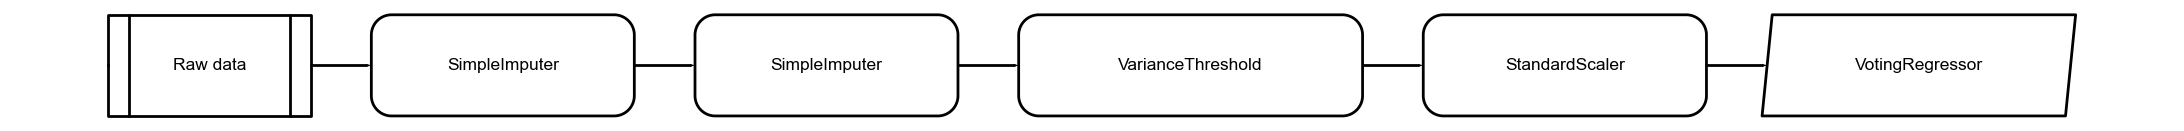

In [35]:
plot_model(blender, plot='pipeline')

### 4.9.2 Find best weights using VotingRegressor()

In [37]:
y = train_df["ttf"]
X = train_df.drop(columns = ["ttf" ])
feature_names=X.columns

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=47)


In [46]:
top03_copy = top03

In [47]:
# use sklearn vote weights
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    now = datetime.datetime.now()
    print(i, now)
    for j in np.arange(0.1,1, 0.1):
        
#         for k in np.arange(0.1,1, 0.1):
        k = 1 - i - j
        if k > 0:            
            rg_voting3 = VotingRegressor(estimators = [('est1', top03_copy[0]), ('est2', top03_copy[1]), 
                                           ('est3', top03_copy[2])], n_jobs = -1,weights = [i, j, k])
            rg_votine3.fit(X_train, y_train)
            pred = rg_voting3.predict(X_test)
            score = mean_absolute_error(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

0.1 2022-09-28 09:17:16.989884
0.2 2022-09-28 09:31:41.645098
0.30000000000000004 2022-09-28 09:45:10.687103
0.4 2022-09-28 09:59:23.741628
0.5 2022-09-28 10:12:46.131297
0.6 2022-09-28 10:22:33.533383
0.7000000000000001 2022-09-28 10:30:46.053046
0.8 2022-09-28 10:36:00.303100
0.9 2022-09-28 10:38:07.351452


In [48]:
# Save the results in a data frame

test_scores03 = pd.DataFrame()
test_scores03['Weight1'] = weights1
test_scores03['Weight2'] = weights2
test_scores03['Weight3'] = weights3
test_scores03['Test MAE'] = scores

condition = (test_scores03['Weight3'] >=0.01)

test_scores03 = test_scores03.loc[condition]
# Sort the values to see the different test scores depending on the weights
test_scores03.sort_values(by = 'Test MAE', ascending = True).head(15)

,Weight1,Weight2,Weight3,Test MAE
18,0.3,0.4,0.3,1.933345
23,0.4,0.3,0.3,1.933742
12,0.2,0.5,0.3,1.933753
19,0.3,0.5,0.2,1.934089
24,0.4,0.4,0.2,1.934146
17,0.3,0.3,0.4,1.934262
11,0.2,0.4,0.4,1.934363
27,0.5,0.2,0.3,1.934498
28,0.5,0.3,0.2,1.934642
13,0.2,0.6,0.2,1.934643


In [49]:
rg_voting03 = VotingRegressor(estimators = [('est1', top03_copy[0]), ('est2', top03_copy[1]), 
                                           ('est3', top03_copy[2])], n_jobs = -1,weights = test_scores03.sort_values(by = 'Test MAE', ascending = True).iloc[0,:3])
#Fit and predict

rg_voting03.fit(X_train, y_train)
pred_voting03 = rg_voting.predict(X_test)

In [52]:
rg_voting03

VotingRegressor(estimators=[('est1',
                             ExtraTreesRegressor(n_jobs=-1, random_state=123)),
                            ('est2',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('est3', LGBMRegressor(random_state=123))],
                n_jobs=-1,
                weights=Weight1    0.3
Weight2    0.4
Weight3    0.3
Name: 18, dtype: float64)

In [50]:
mean_absolute_error(pred_voting03,y_test)

1.9399943565027011

In [36]:
top3_copy = top3

In [39]:
# use sklearn vote weights
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    now = datetime.datetime.now()
    print(i, now)
    for j in np.arange(0.1,1, 0.1):
        
#         for k in np.arange(0.1,1, 0.1):
        k = 1 - i - j
        if k > 0:            
            rg_voting = VotingRegressor(estimators = [('est1', top3_copy[0]), ('est2', top3_copy[1]), 
                                           ('est3', top3_copy[2])], n_jobs = -1,weights = [i, j, k])
            rg_voting.fit(X_train, y_train)
            pred = rg_voting.predict(X_test)
            score = mean_absolute_error(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

0.1 2022-09-28 03:07:25.149322
0.2 2022-09-28 03:46:11.877324
0.30000000000000004 2022-09-28 04:18:45.659149
0.4 2022-09-28 04:46:33.957600
0.5 2022-09-28 05:09:43.945261
0.6 2022-09-28 05:28:12.737675
0.7000000000000001 2022-09-28 05:42:14.058926
0.8 2022-09-28 05:51:40.710478
0.9 2022-09-28 05:56:18.151890


In [40]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test MAE'] = scores

condition = (test_scores['Weight3'] >=0.01)

test_scores = test_scores.loc[condition]
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test MAE', ascending = True).head(15)

,Weight1,Weight2,Weight3,Test MAE
22,0.4,0.2,0.4,1.920160
26,0.5,0.1,0.4,1.920765
17,0.3,0.3,0.4,1.920923
21,0.4,0.1,0.5,1.921346
16,0.3,0.2,0.5,1.921347
27,0.5,0.2,0.3,1.921377
23,0.4,0.3,0.3,1.921578
10,0.2,0.3,0.5,1.922644
11,0.2,0.4,0.4,1.922861
30,0.6,0.1,0.3,1.922949


In [54]:
rg_voting = VotingRegressor(estimators = [('est1', top3_copy[0]), ('est2', top3_copy[1]), 
                                           ('est3', top3_copy[2])], n_jobs = -1,weights = test_scores.sort_values(by = 'Test MAE', ascending = True).iloc[0,:3])
#Fit and predict

rg_voting.fit(X_train, y_train)
pred_voting = rg_voting.predict(X_test)

In [55]:
mean_absolute_error(pred_voting,y_test)

1.9201598508078885

In [56]:
rg_voting

VotingRegressor(estimators=[('est1',
                             RandomForestRegressor(n_jobs=-1,
                                                   random_state=123)),
                            ('est2', LGBMRegressor(random_state=123)),
                            ('est3',
                             GradientBoostingRegressor(learning_rate=0.15,
                                                       max_depth=7,
                                                       max_features=1.0,
                                                       min_impurity_decrease=0.02,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5,
                                                       n_estimators=230,
                                                       random_state=123,
                                                       subsample=0.85))],
                n_jobs=-1,
                weights=Weight1    0.4
Weight2    0.2
Weight3    0.4
Name: 22, dtype: float64)

## 4.10 Plot

### 4.10.1 Feature Importance Plot

In [ ]:
# plot_model(best_mae_model)

In [ ]:
# plot_model(best_mae_model, plot = 'error')

* When label is high, underestimated
* When label is low, overestimated
* Some labels with values close to zero are significantly overestimated

## 4.11 Predict on test / hold-out Sample

In [ ]:
# predict_model(best_mae_model);

## 4.12 Submit to Kaggle

In [57]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
seg_len = 150_000

In [58]:
# time-domain features
qt5 = lambda x: x.quantile(0.05)
qt25 = lambda x: x.quantile(0.25)
qt75 = lambda x: x.quantile(0.75)
qt95 = lambda x: x.quantile(0.95)
iqr = lambda x : qt75(x) - qt25(x)
statistics_names = ["mean","median","std","kurt","skew","min","max","qt5","qt25","qt75","qt95","iqr"]
statistics_funs = ["mean","median","std","kurt","skew","min","max",qt5,qt25,qt75,qt95,iqr]

rol_funcs_names = ["mean","std","kurt","skew"]
windows = [10, 100,1000]
rol_feature_names = ["rol" + str(w) + "_" + func1 + "_"+ func2 \
                     for w in windows\
                     for func1 in rol_funcs_names \
                     for func2 in statistics_names \
                     ]

# envelope_features
envelope_names = ["rol" + str(w) + "envelope_" + fun \
                  for w in windows\
                  for fun in ["mean","std","max","kurt","skew"]]

# lag_features
lag_names = ["lag" + str(i) for i in range(1,12)]

tfeature_names = statistics_names + rol_feature_names + envelope_names + lag_names

def chunk_statistics(chunk):
    temp_np = chunk['acoustic_data'].agg(statistics_funs)
    return temp_np.tolist()

def rolling_statistics(chunk, windows):
    rtn_list = []

    for w in windows:
        temp_rolling = chunk['acoustic_data'].rolling(w, center = True)
        temp_df = temp_rolling.agg(rol_funcs_names).agg(statistics_funs)
        temp_list = temp_df.values.ravel().tolist()
        rtn_list = temp_list + rtn_list
    return rtn_list     

def rectify_statistics(chunk, windows):
    envelope_stats_list = []
    signal_rectified = chunk['acoustic_data'].apply(np.abs)
    for w in windows:
        signal_envelope = signal_rectified.rolling(w, center = True).mean()
        signal_envelope_list = signal_envelope.agg(["mean","std","max","kurt","skew"]).tolist()
        envelope_stats_list = envelope_stats_list + signal_envelope_list
    return envelope_stats_list

def ac_features(chunk):    
    temp = acf(chunk['acoustic_data'], nlags=11, fft = True)
    return temp[1:].tolist()

def generate_stats(chunk,windows):
    """ statistic feature in time_domain"""
    rol_stats_list = rolling_statistics(chunk, windows)
    stats_list = chunk_statistics(chunk)
    envelope_stats_list = rectify_statistics(chunk, windows)
    ac_list = ac_features(chunk)
    tfeature_list = stats_list +  rol_stats_list + envelope_stats_list + ac_list
    return tfeature_list

In [135]:
# frequency features
# rolling statistic feature in time_domain
freq_stat_names = ["mean","median","std","kurt","skew","min","max","qt25","qt75","iqr"]
freq_windows = [5000, 10000, 50000] #
amp_spectrum_rol_feature_names = ["amp_sp_rol" + str(w) + "_"+ freq_stat_name \
                                  for w in freq_windows \
                                  for freq_stat_name in freq_stat_names] 
amp_spectrum_rol_seg_feature_names = ["amp_sp_rol" + str(w) + "seg_" + str(i) for w in freq_windows for i in range(10)]

# rolling functions for amplitude spectrum
def roll_seg_median(spectrum_np, seg_len):
    interval = int(seg_len/20)
    roll_spectrum_seg_median = []
    for i in range(10):
        idx = list((np.arange(0,interval) + interval * i))
        roll_spectrum_seg_median.append(np.median(spectrum_np[idx]))

    return roll_spectrum_seg_median

def rolling_amp_spectrum(chunk, windows, seg_len):
    roll_amp_spectrum_statistics = []
    roll_amp_spectrum_seg_median= []
    sp = np.fft.fft(chunk['acoustic_data'])
    amp_sp = pd.Series(np.abs(sp))[0:int(seg_len/2)]
    for w in windows:
        temp_rolling_median = amp_sp.rolling(w, center = True).agg(np.median)
        roll_amp_spectrum_statistics.append(temp_rolling_median.
                                            agg(["mean","median","std","kurt","skew","min","max",qt25,qt75,iqr])) #   
        roll_amp_spectrum_seg_median.append(roll_seg_median(temp_rolling_median, seg_len)) 
    roll_amp_spectrum_statistics = [j for sub in roll_amp_spectrum_statistics for j in sub]        
    roll_amp_spectrum_seg_median = [j for sub in roll_amp_spectrum_seg_median for j in sub]

    return roll_amp_spectrum_statistics + roll_amp_spectrum_seg_median

# amplitude spectrum trend (ac)
def ac_spectrum(chunk):
    sp = np.fft.fft(chunk['acoustic_data'])
    SP = np.abs(sp)
    ac_spectrum_list = acf(SP, nlags=11, fft = True)[1:]
    return ac_spectrum_list


In [60]:
!pip install librosa

  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
     ---------------------------------------- 1.0/1.0 MB 4.6 MB/s eta 0:00:00
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached audioread-3.0.0-py3-none-any.whl
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)


In [61]:
# spectrogram features
import librosa as lr
def spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW):    
    spec = lr.stft(chunk['acoustic_data'].values.astype(float), hop_length = HOP_LENGTH, n_fft = SIZE_WINDOW)
    spec_rectified = np.abs(spec)
    mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S = spec_rectified))
    mean_centroids = np.mean(lr.feature.spectral_centroid(S = spec_rectified))
    return mean_centroids, mean_bandwidth


In [147]:
print(windows, freq_windows)

[10, 100, 1000] [5000, 10000, 50000]


In [148]:
# transform testfiles to frequncy domain features 
j = -1

seg_id =[]
tfeatures = []

roll_AP_statistics = []
ac_spectrum_list = []

HOP_LENGTH = 2**6
SIZE_WINDOW = 2**7
bandwidths = []
centroids = []

for file in testfiles: 
    chunk = pd.read_csv(file)
    j += 1
    if j % 500 == 0:
        print(j)
        now = datetime.datetime.now()
        print(now)
    
    tfeature_list = generate_stats(chunk, windows)
    tfeatures.append( tfeature_list)

    seg_id.append(file[:-4])

    roll_amp_spectrum_statistics = rolling_amp_spectrum(chunk, freq_windows, seg_len)
    roll_AP_statistics.append(roll_amp_spectrum_statistics)
    
    ac_spectrum_row = ac_spectrum(chunk)
    ac_spectrum_list.append(ac_spectrum_row)
    
    mean_centroids, mean_bandwidth = spectrogram_feature(chunk, HOP_LENGTH, SIZE_WINDOW)
    centroids.append(mean_centroids)
    bandwidths.append(mean_bandwidth)
#     if j > 2:
#         break

tfeature_df = pd.DataFrame(tfeatures, columns = tfeature_names)
roll_AP_statistics_df = pd.DataFrame(roll_AP_statistics, columns = amp_spectrum_rol_feature_names +
                                    amp_spectrum_rol_seg_feature_names)
ac_amp_spec_df = pd.DataFrame(ac_spectrum_list, columns = ['amp_spec_ac' + str(i) for i in range(1,12)])
spectrogram_feature_df = pd.DataFrame({'mean_centroids':centroids, 'bandwidth':bandwidths})



0
2022-09-28 15:01:03.025535
500
2022-09-28 15:24:00.278933
1000
2022-09-28 15:49:00.511626
1500
2022-09-28 16:17:19.638545
2000
2022-09-28 16:48:02.727615
2500
2022-09-28 17:05:58.707659


In [181]:
roll_AP_statistics_df.dropna(axis = 1, inplace = True)
test_df = pd.concat([tfeature_df, 
                     roll_AP_statistics_df, 
                     ac_amp_spec_df, 
                     spectrogram_feature_df], axis = 1) 
test_df.index = pd.Index(seg_id)
test_df.index.name = 'seg_id'
test_df.to_pickle('../../data/test_features.pkl')
test_df.head()

,mean,median,std,kurt,skew,min,max,qt5,qt25,qt75,...,amp_spec_ac4,amp_spec_ac5,amp_spec_ac6,amp_spec_ac7,amp_spec_ac8,amp_spec_ac9,amp_spec_ac10,amp_spec_ac11,mean_centroids,bandwidth
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.0,4.893690,28.837568,0.327908,-75.0,115.0,-2.0,2.0,7.0,...,0.261360,0.275134,0.260425,0.262637,0.255499,0.258394,0.267300,0.266031,3112.048939,3171.512722
seg_0012b5,4.171153,4.0,5.922839,56.218955,0.295708,-140.0,152.0,-2.0,2.0,7.0,...,0.381827,0.384513,0.378006,0.374611,0.381894,0.397440,0.397677,0.380011,3180.347823,3176.973226
seg_00184e,4.610260,5.0,6.946990,162.118284,0.428688,-193.0,248.0,-2.0,2.0,7.0,...,0.479098,0.476925,0.474384,0.462695,0.465657,0.452476,0.460663,0.455640,3121.976243,3182.459843
seg_003339,4.531473,5.0,4.114147,41.241827,0.061889,-93.0,85.0,-1.0,3.0,7.0,...,0.177322,0.184822,0.181377,0.182576,0.185974,0.187201,0.180412,0.182550,3252.088971,3252.565530
seg_0042cc,4.128340,4.0,5.797164,79.539708,0.073898,-147.0,177.0,-2.0,2.0,6.0,...,0.407653,0.420772,0.401238,0.406002,0.389866,0.420416,0.401628,0.405667,3218.904613,3196.817706


### single model prediction

In [150]:
best3_models = [tuned_lightgbm, tuned_rf,  tuned_gbr]
model_names = ['lightgbm', 'rf','gbr']
for idx, single_model in enumerate(best3_models):     
#     single_model.fit(X,y)
    pred_test = predict_model(single_model ,data = test_df)
    pred_label = pd.DataFrame(pred_test['prediction_label'].values, index = test_df.index)
    pred_label.columns = ['time_to_failure']
    pred_label.to_csv('../../data/submission_' + model_names[idx] + '.csv')

### blend model prediction

In [151]:
# blender.fit(X,y)
pred_test = predict_model(blender ,data = test_df)
pred_label = pd.DataFrame(pred_test['prediction_label'].values, index = test_df.index)
pred_label.columns = ['time_to_failure']
pred_label.to_csv('../../data/submission_noweights_voting.csv')

### weighted voting regressor prediction

In [152]:
# rg_voting.fit(X, y)
pred_voting = rg_voting.predict(test_df)
pred_label = pd.DataFrame(pred_voting, index = test_df.index)
pred_label.columns = ['time_to_failure']
pred_label.to_csv('../../data/submission_weighted_voting.csv')

Private Score on kaggle and rank:
* blender no weights: 2.471, 114, <top3%
* gbr: 2.481, 150 
* lightgbr: 2.487
* VotingRegressor with weithts： 2.493
* rf: 2.495



Private Score on kaggle and rank using 243 features on 9/28/2022 is poorer, even though the trainig performance is better:
* blender no weights: 2.505
* gbr: 2.5889 
* lightgbr: 2.5152
* VotingRegressor with weithts： 2.5196
* rf: 2.5115